In [91]:
using CSV, Tables, LinearAlgebra, Random, Gurobi, JuMP, Statistics, DataFrames, JLD2, Dates

# Inputs

In [96]:
# Station information
stations_info = CSV.read("../../data/stations/station_information.csv", DataFrame);

#### for top 30 stations

In [97]:
# Capacity
C_30=CSV.read("../../data/parameters/top30/C.csv", DataFrame, header=false);
# initial bikes availability
y0_30_1=CSV.read("../../data/parameters/top30/y0_00.csv", DataFrame, header=false);
y0_30_2=CSV.read("../../data/parameters/top30/y0_55.csv", DataFrame, header=false);
y0_30_3=CSV.read("../../data/parameters/top30/y0_58.csv", DataFrame, header=false);
# Distances
D_30 = load("../../data/parameters/top30/D.jld2","D_30");
# Feasibility
X_30 = load("../../data/parameters/top30/X.jld2","X_30");
Xfeas_30 = load("../../data/parameters/top30/X_feasible.jld2","Xfeas_30");
# Demand
d_30_1 = load("../../data/parameters/top30/d_1.jld2","d_30_1");
d_30_2 = load("../../data/parameters/top30/d_2.jld2","d_30_2");
d_30_3 = load("../../data/parameters/top30/d_3.jld2","d_30_3");

### for top 50 stations

In [99]:
# Capacity
C_50=CSV.read("../../data/parameters/top50/C.csv", DataFrame, header=false);
# initial bikes availability
y0_50_1=CSV.read("../../data/parameters/top50/y0_00.csv", DataFrame, header=false);
y0_50_2=CSV.read("../../data/parameters/top50/y0_55.csv", DataFrame, header=false);
y0_50_3=CSV.read("../../data/parameters/top50/y0_58.csv", DataFrame, header=false);
# Distances
D_50 = load("../../data/parameters/top50/D.jld2","D_50");
# Feasibility
X_50 = load("../../data/parameters/top50/X.jld2","X_50");
Xfeas_50 = load("../../data/parameters/top50/X_feasible.jld2","Xfeas_50");
# Demand
d_50_1 = load("../../data/parameters/top50/d_1.jld2","d_50_1");
d_50_2 = load("../../data/parameters/top50/d_2.jld2","d_50_2");
d_50_3 = load("../../data/parameters/top50/d_3.jld2","d_50_3");

### Robustness: Create slightly different demand for d1, using d2

In [100]:
function create_d_bis(d_1,d_2)
    diff = d_2 - d_1
    n_stations = size(d_1,1)
    d_bis=zeros(n_stations,n_stations,24)
    for i in 1:n_stations
        for j in 1:n_stations
            for l in 1:24
                ecart=floor(diff[i,j,l]/2)
                if ecart>0
                    d_bis[i,j,l] = d_1[i,j,l] + rand(0:ecart)
                else
                    d_bis[i,j,l] = d_1[i,j,l] + rand(ecart:0)
                end
            end
        end
    end
    return d_bis
end

create_d_bis (generic function with 1 method)

In [101]:
d_30_1bis=create_d_bis(d_30_1, d_30_2);
d_50_1bis=create_d_bis(d_50_1, d_50_2);

# Model - Sequential

In [102]:
function solve_sequential_model(K,S,C,D,X,y0,d,lambda,time_limit)
    model = Model(Gurobi.Optimizer)
    # set_optimizer_attribute(model, "OutputFlag", 0)
    set_optimizer_attribute(model, "TimeLimit", time_limit)

    n_stations, _, n_hours = size(d)
    C=C[!,1]
    y0=y0[!,1]
    # Decision variables
    @variable(model, x[1:n_stations, 1:n_stations, 1:K, 1:n_hours], Bin)
    @variable(model, v[1:n_stations, 1:n_stations, 1:K, 1:n_hours], Bin)
    @variable(model, 0 <= z[1:n_stations, 1:n_stations, 1:K, 1:n_hours], Int)
    @variable(model, 0 <= y[1:n_stations, 1:n_hours]) # Int by definition of the constraints
    @variable(model, 0 <= w[1:n_stations, 1:n_stations, 1:n_hours], Int)
    @variable(model, 0 <= u[1:n_stations, 1:n_stations, 1:n_hours])

    # Add constraints:
    # Stations capacity
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], y[i,t] <= C[i])
    # Flow balance 
    @constraint(model, [i in 1:n_stations, t in 2:n_hours], y[i,t] - y[i,t-1] == sum(w[j,i,t] for j in 1:n_stations)-sum(w[i,j,t] for j in 1:n_stations)-sum(z[i,j,k,t] for j in 1:n_stations, k in 1:K)+sum(z[j,i,k,t] for j in 1:n_stations, k in 1:K))
    # Flow balance for the first hour 
    @constraint(model, [i in 1:n_stations], y[i,1] - y0[i] == sum(w[j,i,1] for j in 1:n_stations)-sum(w[i,j,1] for j in 1:n_stations)-sum(z[i,j,k,1] for j in 1:n_stations, k in 1:K)+sum(z[j,i,k,1] for j in 1:n_stations, k in 1:K))
    # Vans capacity
    @constraint(model, [i in 1:n_stations, j in 1:n_stations, k in 1:K, t in 1:n_hours], z[i,j,k,t] <= S)
    # Users travel availability
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], -y[i,t] <= sum(w[j,i,t] for j in 1:n_stations) - sum(w[i,j,t] for j in 1:n_stations))
    @constraint(model, [i in 1:n_stations, t in 1:n_hours], sum(w[j,i,t] for j in 1:n_stations) - sum(w[i,j,t] for j in 1:n_stations)<= C[i] - y[i,t])
    
    # Max 1 rebalancing per hour per van
    @constraint(model, [k in 1:K, t in 1:n_hours], sum(x[i,j,k,t] for i in 1:n_stations, j in 1:n_stations) == 1)
    @constraint(model, [k in 1:K, t in 1:n_hours], sum(v[i,j,k,t] for i in 1:n_stations, j in 1:n_stations) == 1)
    # Rebalancing feasibility
    @constraint(model, [i in 1:n_stations, j in 1:n_stations, k in 1:K, t in 1:n_hours], z[i,j,k,t] <= S*x[i,j,k,t])
    for i in 1:n_stations
        for j in 1:n_stations
            if X[i,j] == 0
                for k in 1:K
                    for t in 1:n_hours
                        @constraint(model, x[i,j,k,t] == 0)
                        @constraint(model, v[i,j,k,t] == 0)
                        @constraint(model, z[i,j,k,t] == 0)
                    end
                end
            end
        end
    end
   # Vans must travel sequentially
    @constraint(model, [i in 1:n_stations, k in 1:K, t in 2:n_hours], sum(x[i,j,k,t] for j in 1:n_stations) <= sum(v[l,i,k,t-1] for l in 1:n_stations))
    @constraint(model, [j in 1:n_stations, k in 1:K, t in 1:n_hours], sum(v[j,l,k,t] for l in 1:n_stations) <= sum(x[i,j,k,t] for i in 1:n_stations))
    # Users travel is inferior to the demand and definition of u
    @constraint(model, [i in 1:n_stations, j in 1:n_stations, t in 1:n_hours], u[i,j,t] >= d[i,j,t] - w[i,j,t])
    @constraint(model, [i in 1:n_stations, j in 1:n_stations, t in 1:n_hours], d[i,j,t] >= w[i,j,t])

    # Set objective
    @objective(model, Min, sum(u[i,j,t] for i in 1:n_stations, j in 1:n_stations, t in 1:n_hours)+lambda*sum(D[i,j]*(x[i,j,k,t]+v[i,j,k,t]/10) for i in 1:n_stations, j in 1:n_stations, k in 1:K, t in 1:n_hours))
    
    # Solve the model
    optimize!(model)
    
    # Export the solution
    x_sol = value.(x)
    v_sol = value.(v)
    z_sol = value.(z)
    w_sol = value.(w)
    y_sol = value.(y)
    u_sol = value.(u)

    # current date without millisecond and no colon
    current_date = Dates.format(now(), "yyyy-mm-ddTHHMMSS")
    folder = "../../results/data/"*string(current_date)*"_nstations_"*string(n_stations)*"_nvans_"*string(K)*"_capacity_"*string(S)*"_lambda_"*string(lambda)*"_timelimit_"*string(time_limit)*"/"
    mkdir(folder)
    CSV.write(folder*"x.csv", Tables.table(reshape(x_sol,:)), writeheader=false)
    CSV.write(folder*"v.csv", Tables.table(reshape(v_sol,:)), writeheader=false)
    CSV.write(folder*"z.csv", Tables.table(reshape(z_sol,:)), writeheader=false)
    CSV.write(folder*"w.csv", Tables.table(reshape(w_sol,:)), writeheader=false)
    CSV.write(folder*"y.csv", Tables.table(reshape(y_sol,:)), writeheader=false)
    CSV.write(folder*"u.csv", Tables.table(reshape(u_sol,:)), writeheader=false)
    CSV.write(folder*"d.csv", Tables.table(reshape(d,:)), writeheader=false)

    return value.(x), value.(v), value.(w), value.(u), value.(y), value.(z), objective_value(model)
end

solve_sequential_model (generic function with 1 method)

### Result export, display

In [55]:
function export_sequential_results(z,v)
    z_nonzero = Tuple.(findall(x -> x != 0, z))[:,:]
    nb_rebal = size(z_nonzero)[1]
    new=zeros(nb_rebal,5)
    for i=1:nb_rebal
        indices=collect(z_nonzero[i])
        new[i,1:4]=indices # indices of rebalancing
        new[i,5]=z[indices[1],indices[2],indices[3],indices[4]] # nb of bikes
    end
    v_nonzero = Tuple.(findall(x -> x != 0, v))[:,:]
    nb_rebal = size(v_nonzero)[1]
    new2=zeros(nb_rebal,5)
    for i=1:nb_rebal
        indices=collect(v_nonzero[i])
        new2[i,1:4]=indices # indices of rebalancing
        new2[i,5]=0
    end
    return vcat(new,new2)
end

export_sequential_results (generic function with 1 method)

In [56]:
function print_results(results)
    for i=1:size(results)[1]
        println("Rebalancing from station ",results[i,1], " to ", results[i,2], "by van ", results[i,3], " at hour ", results[i,4]," of ", results[i,5]," bikes ")
    end
end

print_results (generic function with 1 method)

### Parameters

In [57]:
# Number of vans
K=2
# Capacity of vans
S=25
# Trade-off for multi-objective
lambda=15; # to be tuned according to the objectives scales

## Solve for Day 1

### with top 30 stations

In [110]:
x_1,v_1,w_1,u_1,y_1,z_1,obj_1=solve_sequential_model(K,S,C_30,D_30,Xfeas_30,y0_30_1,d_30_1,lambda,120);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 120
Set parameter TimeLimit to value 120
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 153154 rows, 185256 columns and 716173 nonzeros
Model fingerprint: 0x98801e2e
Variable types: 23808 continuous, 161448 integer (92256 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+03]
Presolve removed 106612 rows and 55931 columns
Presolve time: 0.45s
Presolved: 46542 rows, 129325 columns, 432072 nonzeros
Variable types: 0 continuous, 129325 integer (85706 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.077257e+02, 

In [111]:
findall(x -> x >0.5, z_1[:,:,:,:])

11-element Vector{CartesianIndex{4}}:
 CartesianIndex(2, 20, 1, 1)
 CartesianIndex(11, 4, 2, 1)
 CartesianIndex(14, 4, 2, 13)
 CartesianIndex(7, 14, 2, 14)
 CartesianIndex(20, 30, 1, 15)
 CartesianIndex(30, 2, 1, 16)
 CartesianIndex(2, 20, 1, 17)
 CartesianIndex(20, 30, 1, 18)
 CartesianIndex(7, 21, 2, 18)
 CartesianIndex(21, 7, 2, 19)
 CartesianIndex(20, 2, 1, 21)

In [112]:
findall(x -> x >0.5, x_1[:,:,:,:])

48-element Vector{CartesianIndex{4}}:
 CartesianIndex(2, 20, 1, 1)
 CartesianIndex(11, 4, 2, 1)
 CartesianIndex(20, 20, 1, 2)
 CartesianIndex(4, 4, 2, 2)
 CartesianIndex(20, 20, 1, 3)
 CartesianIndex(14, 14, 2, 3)
 CartesianIndex(20, 20, 1, 4)
 CartesianIndex(14, 14, 2, 4)
 CartesianIndex(20, 20, 1, 5)
 CartesianIndex(14, 14, 2, 5)
 CartesianIndex(20, 20, 1, 6)
 CartesianIndex(14, 14, 2, 6)
 CartesianIndex(20, 20, 1, 7)
 ⋮
 CartesianIndex(30, 30, 1, 19)
 CartesianIndex(21, 7, 2, 19)
 CartesianIndex(30, 30, 1, 20)
 CartesianIndex(7, 7, 2, 20)
 CartesianIndex(20, 2, 1, 21)
 CartesianIndex(7, 7, 2, 21)
 CartesianIndex(2, 2, 1, 22)
 CartesianIndex(7, 7, 2, 22)
 CartesianIndex(2, 2, 1, 23)
 CartesianIndex(7, 7, 2, 23)
 CartesianIndex(2, 2, 1, 24)
 CartesianIndex(7, 7, 2, 24)

In [113]:
# Count the number of non-moving trips
non_moving=sum(sum(x_1[i,i,:,:] for i in 1:30))
# Count the number of rebalancing trips
rebalancing=sum(sum(x_1[i,j,:,:] for i in 1:30, j in 1:30))-non_moving

11.0

In [114]:
#results = export_sequential_results(z_1,v_1);
#CSV.write("../../results/data/sequential_model_day1/results.csv", results |> Tables.table)
# print_results(print_results(z_1))

In [115]:
#n_stations, _, n_hours = size(d_new)
#println(sum(u_1[i,j,t] for i in 1:n_stations, j in 1:n_stations, t in 1:n_hours))
#println(sum(D_new[i,j]*x_1[i,j,k,t] for i in 1:n_rebal, j in 1:n_rebal, k in 1:K, t in 1:n_hours))

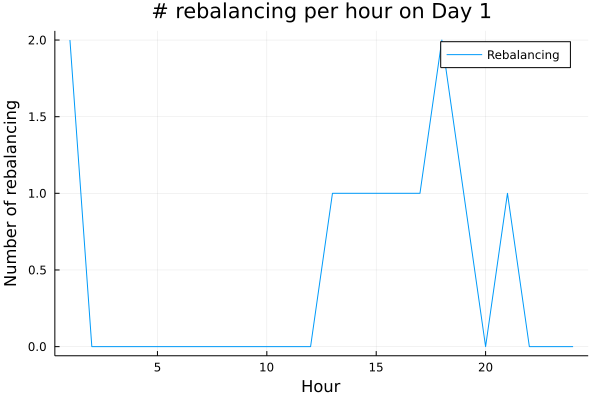

In [121]:
using Plots
plot([(sum(sum(x_1[i,j,:,t] for i in 1:30, j in 1:30))-sum(sum(x_1[i,i,:,t] for i in 1:30))) for t=1:24], label="Rebalancing", xlabel="Hour", ylabel="Number of rebalancing", title="# rebalancing per hour on Day 1")

## Solve for Day 1 - bis

In [119]:
x_1_bis,v_1_bis,w_1_bis,u_1_bis,y_1_bis,z_1_bis,obj_1_bis=solve_sequential_model(K,S,C_30,D_30,Xfeas_30,y0_30_1,d_30_1bis,lambda,120);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 120
Set parameter TimeLimit to value 120
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 153154 rows, 185256 columns and 716173 nonzeros
Model fingerprint: 0x970fc48b
Variable types: 23808 continuous, 161448 integer (92256 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+03]
Presolve removed 106656 rows and 56023 columns
Presolve time: 0.46s
Presolved: 46498 rows, 129233 columns, 431523 nonzeros
Variable types: 0 continuous, 129233 integer (85765 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.01s

Solved with dual simplex

Root relaxation: objective 2.103149e+02, 

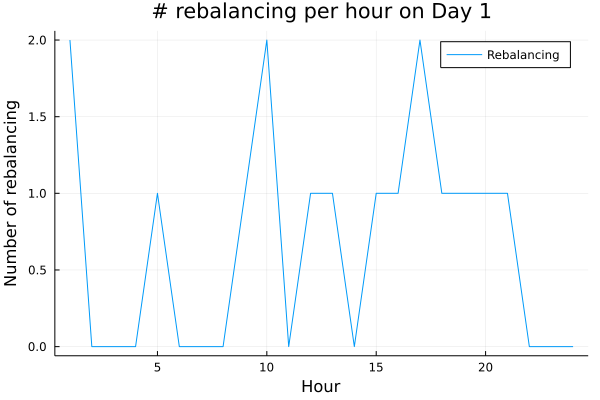

In [122]:
using Plots
plot([(sum(sum(x_1_bis[i,j,:,t] for i in 1:30, j in 1:30))-sum(sum(x_1_bis[i,i,:,t] for i in 1:30))) for t=1:24], label="Rebalancing", xlabel="Hour", ylabel="Number of rebalancing", title="# rebalancing per hour on Day 1")

In [123]:
#res_1_bis=export_results(z_1_bis)
#res_1_bis

## Solve for Day 8

In [124]:
x_2,v_2,w_2,u_2,y_2,z_2,obj_2=solve_sequential_model(K,S,C_30,D_30,Xfeas_30,y0_30_1,d_30_2,lambda,120);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 120
Set parameter TimeLimit to value 120
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 153154 rows, 185256 columns and 716173 nonzeros
Model fingerprint: 0x7ffac72a
Variable types: 23808 continuous, 161448 integer (92256 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+03]
Presolve removed 106659 rows and 56144 columns
Presolve time: 0.49s
Presolved: 46495 rows, 129112 columns, 430761 nonzeros
Variable types: 0 continuous, 129112 integer (85509 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.009821e+02, 

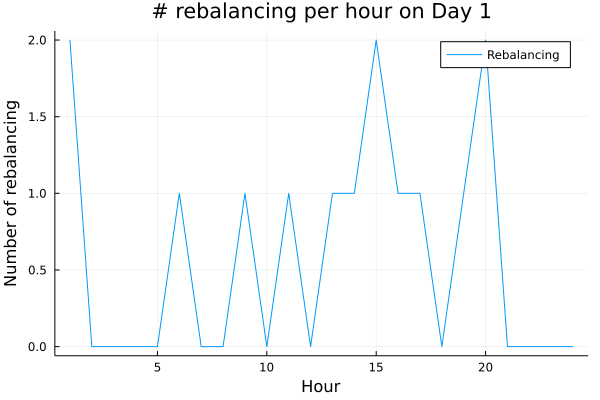

In [125]:
using Plots
plot([(sum(sum(x_2[i,j,:,t] for i in 1:30, j in 1:30))-sum(sum(x_2[i,i,:,t] for i in 1:30))) for t=1:24], label="Rebalancing", xlabel="Hour", ylabel="Number of rebalancing", title="# rebalancing per hour on Day 1")

In [126]:
#res_2=export_results(z_2)

## Solve for Day 15

In [127]:
x_3,v_3,w_3,u_3,y_3,z_3,obj_3=solve_sequential_model(K,S,C_30,D_30,Xfeas_30,y0_30_1,d_30_3,lambda,120);

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-04
Set parameter TimeLimit to value 120
Set parameter TimeLimit to value 120
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 153154 rows, 185256 columns and 716173 nonzeros
Model fingerprint: 0xe2479d3c
Variable types: 23808 continuous, 161448 integer (92256 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [2e-01, 2e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 7e+03]
Presolve removed 106637 rows and 55932 columns
Presolve time: 0.44s
Presolved: 46517 rows, 129324 columns, 431878 nonzeros
Variable types: 0 continuous, 129324 integer (85470 binary)

Deterministic concurrent LP optimizer: primal and dual simplex
Showing first log only...

Concurrent spin time: 0.00s

Solved with dual simplex

Root relaxation: objective 3.365569e+02, 

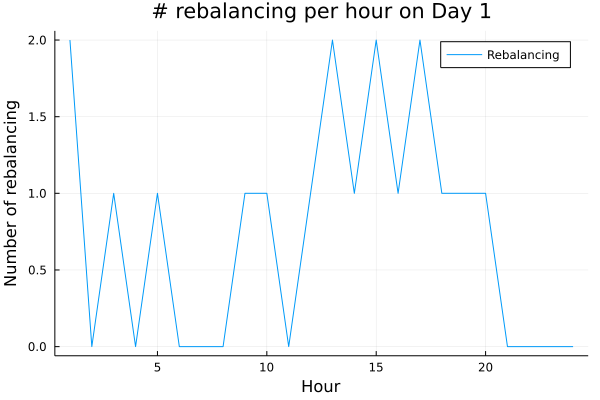

In [128]:
using Plots
plot([(sum(sum(x_3[i,j,:,t] for i in 1:30, j in 1:30))-sum(sum(x_3[i,i,:,t] for i in 1:30))) for t=1:24], label="Rebalancing", xlabel="Hour", ylabel="Number of rebalancing", title="# rebalancing per hour on Day 1")

In [129]:
#res_3=export_results(z_3)